# Designing an MLB database from Retrosheet statistics  <font style="color:rgb(0,100,200)"><i> (work in progress) </i></font>

In this project we build a database from data on the [Major League Baseball](https://www.mlb.com/) available on the [Retrosheet](https://www.retrosheet.org/) website, which compiles statistics on baseball games from the 1800s to today.
We will use several data files: 
* `gl1871_2019.zip` contains the main data files
* `parkcode.txt`, `personcode.txt`, and `TEAMABR.TXT` are three helper files containing additional data, 
* `glfields.txt` defines the fields included in `game_log.csv`. 

The main aim of this project is to learn how to design and build an SQL database using Pandas.

## Exploratory Data Analysis

We first import the modules we will need:

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sqlite3
from IPython.core.display import display, SVG

# to display all columns (no dataset we will use has more than 180 of them)
pd.set_option('max_columns', 180) 

To ease the analysis, we first extract the data files from `gl1871_2019.zip` and combine them in the dataframe `df`.

In [2]:
# first year to be analyzed
first_year = 1871
# last year to be analyzed
last_year = 2019

path = '../Data/Retrosheet_DQ/'
int_folder = path+'int_files'
zip_file = path+'gl1871_2019.zip'

# create the folder for the data files
!mkdir $int_folder

# extract the data files (requires 7zip to be installed)
!7z e $zip_file -o$int_folder

# read the data files
list_df = []
for i in range(first_year, last_year+1):
    list_df.append(pd.read_csv(int_folder + '/GL' + str(i) + '.TXT', header=None))
# reset the index and delete the previous one
game_log = pd.concat(list_df).reset_index().iloc[:,1:] 

# delete the separate data files
!rm -r $int_folder


7-Zip [64] 16.02 : Copyright (c) 1999-2016 Igor Pavlov : 2016-05-21
p7zip Version 16.02 (locale=en_GB.UTF-8,Utf16=on,HugeFiles=on,64 bits,8 CPUs Intel(R) Core(TM) i7-4700HQ CPU @ 2.40GHz (306C3),ASM,AES-NI)

Scanning the drive for archives:
  0M Scan ../Data/Retrosheet_D                              1 file, 33077332 bytes (32 MiB)

Extracting archive: ../Data/Retrosheet_DQ/gl1871_2019.zip
--
Path = ../Data/Retrosheet_DQ/gl1871_2019.zip
Type = zip
Physical Size = 33077332

     16% 53 - GL1924.T                   32% 80 - GL1951.T                   48% 102 - GL1973.TX                     65% 119 - GL1990.TX                     80% 132 - GL2003.TX                     85% 136 - GL2007.TX                     89% 140 - GL2011.TX                    Everything is Ok

Files: 149
Size:       217783142
Compressed: 33077332


We now want to give names to the columns of `game_log` and save it in the dataframe `game_log.csv`. 
To this end, we first read the description of the columns in `glfields.txt`.

In [3]:
!cat $path'glfields.txt'

Field(s)  Meaning
    1     Date in the form "yyyymmdd"
    2     Number of game:
             "0" -- a single game
             "1" -- the first game of a double (or triple) header
                    including seperate admission doubleheaders
             "2" -- the second game of a double (or triple) header
                    including seperate admission doubleheaders
             "3" -- the third game of a triple-header
             "A" -- the first game of a double-header involving 3 teams
             "B" -- the second game of a double-header involving 3 teams
    3     Day of week  ("Sun","Mon","Tue","Wed","Thu","Fri","Sat")
  4-5     Visiting team and league
    6     Visiting team game number
          For this and the home team game number, ties are counted as
          games and suspended games are counted from the starting
          rather than the ending date.
  7-8     Home team and league
    9     Home team game number
10-11     Visiting and home team score (unquoted)


In [4]:
# column names
columns = [
    "date",
    "number_game",
    "day",
    "visiting_team",
    "visiting_team_league",
    "visiting_game_number",
    "home_team",
    "home_team_league",
    "home_game_number",
    "visiting_team_score",
    "home_team_score",
    "outs", 
    "day/night",
    "completion",
    "forfeit",
    "protest",
    "park_id",
    "attendance",
    "time_min",
    "visiting_line_score",
    "home_line_score",
    "visiting_at-bats",
    "visiting_hits",
    "visiting_doubles",
    "visiting_triples",
    "visiting_homeruns",
    "visiting_RBI",
    "visiting_sacrifice_hits",
    "visiting_sacrifice_flies",
    "visiting_hit-by-pitch",
    "visiting_walks",
    "visiting_intentional_walks",
    "visiting_strikeouts",
    "visiting_stolen",
    "visiting_caught",
    "visiting_grounded",
    "visiting_awarded_first",
    "visiting_left_on_base",
    "visiting_pitchers_used",
    "visiting_individual_earned_runs",
    "visiting_team_earned_runs",
    "visiting_wild_pitches",
    "visiting_balks",
    "visiting_putouts",
    "visiting_assists",
    "visiting_errors",
    "visiting_passed_balls",
    "visiting_double_plays",
    "visiting_triple_plays",
    "home_at-bats",
    "home_hits",
    "home_doubles",
    "home_triples",
    "home_homeruns",
    "home_RBI",
    "home_sacrifice_hits",
    "home_sacrifice_flies",
    "home_hit-by-pitch",
    "home_walks",
    "home_intentional_walks",
    "home_strikeouts",
    "home_stolen",
    "home_caught",
    "home_grounded",
    "home_awarded_first",
    "home_left_on_base",
    "home_pitchers_used",
    "home_individual_earned_runs",
    "home_team_earned_runs",
    "home_wild_pitches",
    "home_balks",
    "home_putouts",
    "home_assists",
    "home_errors",
    "home_passed_balls",
    "home_double_plays",
    "home_triple_plays",
    "home_plate_umpire_id",
    "home_plate_umpire_name",
    "1B_umpire_id",
    "1B_umpire_name",
    "2B_umpire_id",
    "2B_umpire_name",
    "3B_umpire_id",
    "3B_umpire_name",
    "LF_umpire_id",
    "LF_umpire_name",
    "RF_umpire_id",
    "RF_umpire_name",
    "visiting_manager_id",
    "visiting_manager_name",
    "home_manager_id",
    "home_manager_name",
    "winning_pitcher_id",
    "winning_pitcher_name",
    "losing_pitcher_id",
    "losing_pitcher_name",
    "saving_pitcher_id",
    "saving_pitcher_name",
    "winning_RBI_batter_id",
    "winning_RBI_batter_name",
    "visiting_starting_pitcher_id",
    "visiting_starting_pitcher_name",
    "home_starting_pitcher_id",
    "home_starting_pitcher_name",
    "visiting_starting_player_1_id",
    "visiting_starting_player_1_name",
    "visiting_starting_player_1_defensive_position",
    "visiting_starting_player_2_id",
    "visiting_starting_player_2_name",
    "visiting_starting_player_2_defensive_position",
    "visiting_starting_player_3_id",
    "visiting_starting_player_3_name",
    "visiting_starting_player_3_defensive_position",
    "visiting_starting_player_4_id",
    "visiting_starting_player_4_name",
    "visiting_starting_player_4_defensive_position",
    "visiting_starting_player_5_id",
    "visiting_starting_player_5_name",
    "visiting_starting_player_5_defensive_position",
    "visiting_starting_player_6_id",
    "visiting_starting_player_6_name",
    "visiting_starting_player_6_defensive_position",
    "visiting_starting_player_7_id",
    "visiting_starting_player_7_name",
    "visiting_starting_player_7_defensive_position",
    "visiting_starting_player_8_id",
    "visiting_starting_player_8_name",
    "visiting_starting_player_8_defensive_position",
    "visiting_starting_player_9_id",
    "visiting_starting_player_9_name",
    "visiting_starting_player_9_defensive_position",
    "home_starting_player_1_id",
    "home_starting_player_1_name",
    "home_starting_player_1_defensive_position",
    "home_starting_player_2_id",
    "home_starting_player_2_name",
    "home_starting_player_2_defensive_position",
    "home_starting_player_3_id",
    "home_starting_player_3_name",
    "home_starting_player_3_defensive_position",
    "home_starting_player_4_id",
    "home_starting_player_4_name",
    "home_starting_player_4_defensive_position",
    "home_starting_player_5_id",
    "home_starting_player_5_name",
    "home_starting_player_5_defensive_position",
    "home_starting_player_6_id",
    "home_starting_player_6_name",
    "home_starting_player_6_defensive_position",
    "home_starting_player_7_id",
    "home_starting_player_7_name",
    "home_starting_player_7_defensive_position",
    "home_starting_player_8_id",
    "home_starting_player_8_name",
    "home_starting_player_8_defensive_position",
    "home_starting_player_9_id",
    "home_starting_player_9_name",
    "home_starting_player_9_defensive_position",
    "additional_information",
    "acquisition_information"
]
game_log.columns = columns
game_log.head(5)

,date,number_game,day,visiting_team,visiting_team_league,visiting_game_number,home_team,home_team_league,home_game_number,visiting_team_score,home_team_score,outs,day/night,completion,forfeit,protest,park_id,attendance,time_min,visiting_line_score,home_line_score,visiting_at-bats,visiting_hits,visiting_doubles,visiting_triples,visiting_homeruns,visiting_RBI,visiting_sacrifice_hits,visiting_sacrifice_flies,visiting_hit-by-pitch,visiting_walks,visiting_intentional_walks,visiting_strikeouts,visiting_stolen,visiting_caught,visiting_grounded,visiting_awarded_first,visiting_left_on_base,visiting_pitchers_used,visiting_individual_earned_runs,visiting_team_earned_runs,visiting_wild_pitches,visiting_balks,visiting_putouts,visiting_assists,visiting_errors,visiting_passed_balls,visiting_double_plays,visiting_triple_plays,home_at-bats,home_hits,home_doubles,home_triples,home_homeruns,home_RBI,home_sacrifice_hits,home_sacrifice_flies,home_hit-by-pitch,home_walks,home_intentional_walks,home_strikeouts,home_stolen,home_caught,home_grounded,home_awarded_first,home_left_on_base,home_pitchers_used,home_individual_earned_runs,home_team_earned_runs,home_wild_pitches,home_balks,home_putouts,home_assists,home_errors,home_passed_balls,home_double_plays,home_triple_plays,home_plate_umpire_id,home_plate_umpire_name,1B_umpire_id,1B_umpire_name,2B_umpire_id,2B_umpire_name,3B_umpire_id,3B_umpire_name,LF_umpire_id,LF_umpire_name,RF_umpire_id,RF_umpire_name,visiting_manager_id,visiting_manager_name,home_manager_id,home_manager_name,winning_pitcher_id,winning_pitcher_name,losing_pitcher_id,losing_pitcher_name,saving_pitcher_id,saving_pitcher_name,winning_RBI_batter_id,winning_RBI_batter_name,visiting_starting_pitcher_id,visiting_starting_pitcher_name,home_starting_pitcher_id,home_starting_pitcher_name,visiting_starting_player_1_id,visiting_starting_player_1_name,visiting_starting_player_1_defensive_position,visiting_starting_player_2_id,visiting_starting_player_2_name,visiting_starting_player_2_defensive_position,visiting_starting_player_3_id,visiting_starting_player_3_name,visiting_starting_player_3_defensive_position,visiting_starting_player_4_id,visiting_starting_player_4_name,visiting_starting_player_4_defensive_position,visiting_starting_player_5_id,visiting_starting_player_5_name,visiting_starting_player_5_defensive_position,visiting_starting_player_6_id,visiting_starting_player_6_name,visiting_starting_player_6_defensive_position,visiting_starting_player_7_id,visiting_starting_player_7_name,visiting_starting_player_7_defensive_position,visiting_starting_player_8_id,visiting_starting_player_8_name,visiting_starting_player_8_defensive_position,visiting_starting_player_9_id,visiting_starting_player_9_name,visiting_starting_player_9_defensive_position,home_starting_player_1_id,home_starting_player_1_name,home_starting_player_1_defensive_position,home_starting_player_2_id,home_starting_player_2_name,home_starting_player_2_defensive_position,home_starting_player_3_id,home_starting_player_3_name,home_starting_player_3_defensive_position,home_starting_player_4_id,home_starting_player_4_name,home_starting_player_4_defensive_position,home_starting_player_5_id,home_starting_player_5_name,home_starting_player_5_defensive_position,home_starting_player_6_id,home_starting_player_6_name,home_starting_player_6_defensive_position,home_starting_player_7_id,home_starting_player_7_name,home_starting_player_7_defensive_position,home_starting_player_8_id,home_starting_player_8_name,home_starting_player_8_defensive_position,home_starting_player_9_id,home_starting_player_9_name,home_starting_player_9_defensive_position,additional_information,acquisition_information
0,18710504,0,Thu,CL1,NaN,1,FW1,NaN,1,0,2,54.0,D,NaN,NaN,NaN,FOR01,200.0,120.0,000000000,010010000,30.0,4.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,-1.0,6.0,1.0,-1.0,-1.0,-1.0,4.0,1.0,1.0,1.0,0.0,0.0,27.0,9.0,0.0,3.0,0.0,0.0,31.0,4.0,1.0,0.0,0.0,2.0,0.0,0.0,0.0,1.0,-1.0,0.0,0.0,-1.0,-1.0,-1.0,3.0,1.0,0.0,0.0,0.0,0.0,27.0,3

In [5]:
# save the result in a csv file
game_log.to_csv(path+'game_log.csv')

We now load the three helper dataframes:

In [6]:
parkcode = pd.read_csv(path + 'parkcode.txt')
personcode = pd.read_csv(path + 'personcode.txt', index_col=False)
teamabr = pd.read_csv(path + 'TEAMABR.TXT', header=None)

Let us now briefly explore the four dataframes. 
We start with the main one.

In [7]:
print(game_log.info(max_cols=180)) 
display(game_log.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 220595 entries, 0 to 220594
Data columns (total 161 columns):
date                                             220595 non-null int64
number_game                                      220595 non-null int64
day                                              220595 non-null object
visiting_team                                    220595 non-null object
visiting_team_league                             219509 non-null object
visiting_game_number                             220595 non-null int64
home_team                                        220595 non-null object
home_team_league                                 219509 non-null object
home_game_number                                 220595 non-null int64
visiting_team_score                              220595 non-null int64
home_team_score                                  220595 non-null int64
outs                                             196961 non-null float64
day/night                    

,date,number_game,day,visiting_team,visiting_team_league,visiting_game_number,home_team,home_team_league,home_game_number,visiting_team_score,home_team_score,outs,day/night,completion,forfeit,protest,park_id,attendance,time_min,visiting_line_score,home_line_score,visiting_at-bats,visiting_hits,visiting_doubles,visiting_triples,visiting_homeruns,visiting_RBI,visiting_sacrifice_hits,visiting_sacrifice_flies,visiting_hit-by-pitch,visiting_walks,visiting_intentional_walks,visiting_strikeouts,visiting_stolen,visiting_caught,visiting_grounded,visiting_awarded_first,visiting_left_on_base,visiting_pitchers_used,visiting_individual_earned_runs,visiting_team_earned_runs,visiting_wild_pitches,visiting_balks,visiting_putouts,visiting_assists,visiting_errors,visiting_passed_balls,visiting_double_plays,visiting_triple_plays,home_at-bats,home_hits,home_doubles,home_triples,home_homeruns,home_RBI,home_sacrifice_hits,home_sacrifice_flies,home_hit-by-pitch,home_walks,home_intentional_walks,home_strikeouts,home_stolen,home_caught,home_grounded,home_awarded_first,home_left_on_base,home_pitchers_used,home_individual_earned_runs,home_team_earned_runs,home_wild_pitches,home_balks,home_putouts,home_assists,home_errors,home_passed_balls,home_double_plays,home_triple_plays,home_plate_umpire_id,home_plate_umpire_name,1B_umpire_id,1B_umpire_name,2B_umpire_id,2B_umpire_name,3B_umpire_id,3B_umpire_name,LF_umpire_id,LF_umpire_name,RF_umpire_id,RF_umpire_name,visiting_manager_id,visiting_manager_name,home_manager_id,home_manager_name,winning_pitcher_id,winning_pitcher_name,losing_pitcher_id,losing_pitcher_name,saving_pitcher_id,saving_pitcher_name,winning_RBI_batter_id,winning_RBI_batter_name,visiting_starting_pitcher_id,visiting_starting_pitcher_name,home_starting_pitcher_id,home_starting_pitcher_name,visiting_starting_player_1_id,visiting_starting_player_1_name,visiting_starting_player_1_defensive_position,visiting_starting_player_2_id,visiting_starting_player_2_name,visiting_starting_player_2_defensive_position,visiting_starting_player_3_id,visiting_starting_player_3_name,visiting_starting_player_3_defensive_position,visiting_starting_player_4_id,visiting_starting_player_4_name,visiting_starting_player_4_defensive_position,visiting_starting_player_5_id,visiting_starting_player_5_name,visiting_starting_player_5_defensive_position,visiting_starting_player_6_id,visiting_starting_player_6_name,visiting_starting_player_6_defensive_position,visiting_starting_player_7_id,visiting_starting_player_7_name,visiting_starting_player_7_defensive_position,visiting_starting_player_8_id,visiting_starting_player_8_name,visiting_starting_player_8_defensive_position,visiting_starting_player_9_id,visiting_starting_player_9_name,visiting_starting_player_9_defensive_position,home_starting_player_1_id,home_starting_player_1_name,home_starting_player_1_defensive_position,home_starting_player_2_id,home_starting_player_2_name,home_starting_player_2_defensive_position,home_starting_player_3_id,home_starting_player_3_name,home_starting_player_3_defensive_position,home_starting_player_4_id,home_starting_player_4_name,home_starting_player_4_defensive_position,home_starting_player_5_id,home_starting_player_5_name,home_starting_player_5_defensive_position,home_starting_player_6_id,home_starting_player_6_name,home_starting_player_6_defensive_position,home_starting_player_7_id,home_starting_player_7_name,home_starting_player_7_defensive_position,home_starting_player_8_id,home_starting_player_8_name,home_starting_player_8_defensive_position,home_starting_player_9_id,home_starting_player_9_name,home_starting_player_9_defensive_position,additional_information,acquisition_information
0,18710504,0,Thu,CL1,NaN,1,FW1,NaN,1,0,2,54.0,D,NaN,NaN,NaN,FOR01,200.0,120.0,000000000,010010000,30.0,4.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,-1.0,6.0,1.0,-1.0,-1.0,-1.0,4.0,1.0,1.0,1.0,0.0,0.0,27.0,9.0,0.0,3.0,0.0,0.0,31.0,4.0,1.0,0.0,0.0,2.0,0.0,0.0,0.0,1.0,-1.0,0.0,0.0,-1.0,-1.0,-1.0,3.0,1.0,0.0,0.0,0.0,0.0,27.0,3

This dataframe has 220595 rows, a header (which we just added) and 161 columns described in `glfields.txt`. 
All columns have some missing values, except `date`, `number_game`, `day`, `visiting_team`, `visiting_game_number`, `home_team`, `home_game_number`, `visiting_team_score`, `home_team_score`, `visiting_manager_ID`, `visiting_manager_name`, `home_manager_ID`, `home_manager_name`, and `acquisition_information`.
The columns `completion`, `forfeit`, `protest`, `LF_umpire_ID`, `RF_umpire_ID`, and `additional_information` have more than 90% of missing values.

Let us now turn to the three helper dataframes:

In [8]:
print(parkcode.info())
print()
print(personcode.info())
print()
print(teamabr.info())

display(parkcode.head())
display(personcode.head())
display(teamabr.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 254 entries, 0 to 253
Data columns (total 9 columns):
PARKID    254 non-null object
NAME      254 non-null object
AKA       57 non-null object
CITY      254 non-null object
STATE     254 non-null object
START     254 non-null object
END       224 non-null object
LEAGUE    189 non-null object
NOTES     129 non-null object
dtypes: object(9)
memory usage: 18.0+ KB
None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21028 entries, 0 to 21027
Data columns (total 7 columns):
ID             21028 non-null object
Last           21028 non-null object
First          20967 non-null object
Play debut     19690 non-null object
Mgr debut      710 non-null object
Coach debut    1638 non-null object
Ump debut      1552 non-null object
dtypes: object(7)
memory usage: 1.1+ MB
None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149 entries, 0 to 148
Data columns (total 6 columns):
0    149 non-null object
1    123 non-null object
2    149 non-null

,PARKID,NAME,AKA,CITY,STATE,START,END,LEAGUE,NOTES
0,ALB01,Riverside Park,NaN,Albany,NY,09/11/1880,05/30/1882,NL,TRN:9/11/80;6/15&9/10/1881;5/16-5/18&5/30/1882
1,ALT01,Columbia Park,NaN,Altoona,PA,04/30/1884,05/31/1884,UA,NaN
2,ANA01,Angel Stadium of Anaheim,Edison Field; Anaheim Stadium,Anaheim,CA,04/19/1966,NaN,AL,NaN
3,ARL01,Arlington Stadium,NaN,Arlington,TX,04/21/1972,10/03/1993,AL,NaN
4,ARL02,Rangers Ballpark in Arlington,The Ballpark in Arlington; Ameriquest Fl,Arlington,TX,04/11/1994,NaN,AL,NaN


,ID,Last,First,Play debut,Mgr debut,Coach debut,Ump debut
0,aardd001,Aardsma,David,04/06/2004,NaN,NaN,NaN
1,aaroh101,Aaron,Hank,04/13/1954,NaN,NaN,NaN
2,aarot101,Aaron,Tommie,04/10/1962,NaN,04/06/1979,NaN
3,aased001,Aase,Don,07/26/1977,NaN,NaN,NaN
4,abada001,Abad,Andy,09/10/2001,NaN,NaN,NaN


,0,1,2,3,4,5
0,BS1,NaN,Boston,Braves,1871,1875
1,CH1,NaN,Chicago,White Stockings,1871,1871
2,CL1,NaN,Cleveland,Forest Cities,1871,1872
3,FW1,NaN,Ft. Wayne,Kekiongas,1871,1871
4,NY2,NaN,New York,Mutuals,1871,1875


The dataframe `parkcode` has 254 rows, a header, and 9 columns, among which `AKA`, `LEAGUE`, and `NOTES` have missing values. 
The dataframe `personcode` has 21028 rows, a header, and 7 columns, all of which have missing values except `ID` and `Last`. 
The dataframe `teamabr` has 149 rows, no header, and 5 columns. 
Only its second column (with index 1) has missing values.

In the following, it will be convenient to have a header for `teamabr`. 
[This Retrosheet webpage](https://www.retrosheet.org/TeamIDs.htm) lists the corresponding fields as Team Abbreviation, League, City, Nickname, First year of this combination, and Last year of this combination (most recent season for current franchises). 
Let us add a header with this information. 
We also convert the column names of the other data frames to lowercase for consistency.

In [9]:
parkcode.columns = parkcode.columns.str.lower()
personcode.columns = personcode.columns.str.lower()
teamabr.columns = ['abbreviation', 'league', 'city', 'nickname', 'first_year', 'last_year']

display(parkcode.head())
display(personcode.head())
display(teamabr.head())

,parkid,name,aka,city,state,start,end,league,notes
0,ALB01,Riverside Park,NaN,Albany,NY,09/11/1880,05/30/1882,NL,TRN:9/11/80;6/15&9/10/1881;5/16-5/18&5/30/1882
1,ALT01,Columbia Park,NaN,Altoona,PA,04/30/1884,05/31/1884,UA,NaN
2,ANA01,Angel Stadium of Anaheim,Edison Field; Anaheim Stadium,Anaheim,CA,04/19/1966,NaN,AL,NaN
3,ARL01,Arlington Stadium,NaN,Arlington,TX,04/21/1972,10/03/1993,AL,NaN
4,ARL02,Rangers Ballpark in Arlington,The Ballpark in Arlington; Ameriquest Fl,Arlington,TX,04/11/1994,NaN,AL,NaN


,id,last,first,play debut,mgr debut,coach debut,ump debut
0,aardd001,Aardsma,David,04/06/2004,NaN,NaN,NaN
1,aaroh101,Aaron,Hank,04/13/1954,NaN,NaN,NaN
2,aarot101,Aaron,Tommie,04/10/1962,NaN,04/06/1979,NaN
3,aased001,Aase,Don,07/26/1977,NaN,NaN,NaN
4,abada001,Abad,Andy,09/10/2001,NaN,NaN,NaN


,abbreviation,league,city,nickname,first_year,last_year
0,BS1,NaN,Boston,Braves,1871,1875
1,CH1,NaN,Chicago,White Stockings,1871,1871
2,CL1,NaN,Cleveland,Forest Cities,1871,1872
3,FW1,NaN,Ft. Wayne,Kekiongas,1871,1871
4,NY2,NaN,New York,Mutuals,1871,1875


We can already determine a few links between the dataframes:
* The column `parkid` in `parkcode` should correspond to `park_id` in `game_log`.
* The column `id` in `personcode` should correspond to columns with IDs of players in `game_log`.
* The column `abbreviation` in `teamabr` should correspond to columns `visiting_team` and `home_team` in `game_log`.

Before going further, let us see which leagues are represented. 

In [10]:
print(game_log['visiting_team_league'].value_counts() 
      + game_log['home_team_league'].value_counts()
      + teamabr['league'].value_counts()
     )
print()
print(parkcode['league'].value_counts())

AA     10103
AL    198751
FL      2495
NL    225852
PL      1072
UA       868
dtype: int64

NL     88
AL     48
AA     34
UA      9
FL      7
PL      2
KC1     1
Name: league, dtype: int64


A Google search indicates that
   * “NL” stands for the National League, one of the two leagues making up the Major League Baseball (MLB)
   * “AL” stands for the American League, the other league of the MLB,
   * “AA” stands for the Double-A, the second-highest level from the Minor League Baseball (MiLB),
   * “UA” stands for the Union association, a league in MLB which lasted only for one season in 1884,
   * “FL” stands for the Florida State League, a league in the class A-advanced, third-highest level of play in the MiLB,
   * “PL” stands for the Players' National League of Professional Base Ball Clubs, a professional American baseball league which lasted only for the season of 1890,
   * “KC1” stands for Kansas City Athletics (which is a team rather than a league, so this entry must be an error).
   
Let us replace “KC1” by the league to which this team belongs, *i.e.*, “AL”.

In [11]:
parkcode['league'] = parkcode['league'].replace({'KC1': 'AL'})
parkcode['league'].value_counts()

NL    88
AL    49
AA    34
UA     9
FL     7
PL     2
Name: league, dtype: int64

## Creating an SQL database

We now wish to create an SQL database with four tables containing the data in the four dataframes. 
To this end, we first define the helper functions `run_command()` and `run_query()` which run, respectively, an SQL command and query, and returns the result as a Pandas dataframe in the second case.

In [12]:
# name of the database
name_db = 'mlb.db'

# path to the database
database = path + name_db

def run_query(q):
    '''
    Opens a connection to the database, runs the query q, returns its result as
    a Pandas dataframe, and closes the connection
    
    q: string
    '''
    with sqlite3.connect(database) as conn:
        return pd.read_sql(q, conn)
    
def run_command(c):
    '''
    Opens a connection to the database, runs the command c,  and closes the 
    connection
    
    c: string
    '''
    with sqlite3.connect(database) as conn:
        conn.execute('PRAGMA foreign_keys = ON;') # to enforce foreign key restraints
        isolation_level = None # to autocommit any changes
        conn.execute(c)

We now add four tables to the new database `mlb.db`. 
We first need to convert columns with indices 19 and 20 in `game_log` to strings to avoid errors, some values being otherwise interpreted as integers. 

In [13]:
game_log['visiting_line_score'] = game_log['visiting_line_score'].astype(str)
game_log['home_line_score'] = game_log['home_line_score'].astype(str)

# set index to False so that no new column is created for the index
with sqlite3.connect(database) as conn:
    game_log.to_sql('game_log', conn, index=False)
    parkcode.to_sql('parkcode', conn, index=False)
    personcode.to_sql('personcode', conn, index=False)
    teamabr.to_sql('teamabr', conn, index=False)

/home/florent/anaconda3/lib/python3.7/site-packages/pandas/core/generic.py:2712: UserWarning: The spaces in these column names will not be changed. In pandas versions < 0.14, spaces were converted to underscores.
  method=method,


The dataframe `game_log` has no obvious column which could be used as primary key. 
We will thus define a composite key following Retrosheet's convention detailed in [this webpage](https://www.retrosheet.org/eventfile.htm). 
The composite key will be a 12-characters string built in the following way: 
* the first three characters are the abbreviation of the home team, 
* the next four characters are the year, 
* the next two are the month, 
* the next two are the day, 
* the final one indicates if it is a single game (0), first game (1), or second game (2).

In [14]:
# Add the column game_id to game_log
c1 = '''
ALTER TABLE game_log
ADD COLUMN game_id;
'''

# Build the game ids
c2 = '''
UPDATE game_log
SET game_id = (home_team || date || number_game)
'''

# Print 10 lines to check the change was made correctly
q_test = '''
SELECT * FROM game_log LIMIT 10
'''

run_command(c1)
run_command(c2)
run_query(q_test)

,date,number_game,day,visiting_team,visiting_team_league,visiting_game_number,home_team,home_team_league,home_game_number,visiting_team_score,home_team_score,outs,day/night,completion,forfeit,protest,park_id,attendance,time_min,visiting_line_score,home_line_score,visiting_at-bats,visiting_hits,visiting_doubles,visiting_triples,visiting_homeruns,visiting_RBI,visiting_sacrifice_hits,visiting_sacrifice_flies,visiting_hit-by-pitch,visiting_walks,visiting_intentional_walks,visiting_strikeouts,visiting_stolen,visiting_caught,visiting_grounded,visiting_awarded_first,visiting_left_on_base,visiting_pitchers_used,visiting_individual_earned_runs,visiting_team_earned_runs,visiting_wild_pitches,visiting_balks,visiting_putouts,visiting_assists,visiting_errors,visiting_passed_balls,visiting_double_plays,visiting_triple_plays,home_at-bats,home_hits,home_doubles,home_triples,home_homeruns,home_RBI,home_sacrifice_hits,home_sacrifice_flies,home_hit-by-pitch,home_walks,home_intentional_walks,home_strikeouts,home_stolen,home_caught,home_grounded,home_awarded_first,home_left_on_base,home_pitchers_used,home_individual_earned_runs,home_team_earned_runs,home_wild_pitches,home_balks,home_putouts,home_assists,home_errors,home_passed_balls,home_double_plays,home_triple_plays,home_plate_umpire_id,home_plate_umpire_name,1B_umpire_id,1B_umpire_name,2B_umpire_id,2B_umpire_name,3B_umpire_id,3B_umpire_name,LF_umpire_id,LF_umpire_name,RF_umpire_id,RF_umpire_name,visiting_manager_id,visiting_manager_name,home_manager_id,home_manager_name,winning_pitcher_id,winning_pitcher_name,losing_pitcher_id,losing_pitcher_name,saving_pitcher_id,saving_pitcher_name,winning_RBI_batter_id,winning_RBI_batter_name,visiting_starting_pitcher_id,visiting_starting_pitcher_name,home_starting_pitcher_id,home_starting_pitcher_name,visiting_starting_player_1_id,visiting_starting_player_1_name,visiting_starting_player_1_defensive_position,visiting_starting_player_2_id,visiting_starting_player_2_name,visiting_starting_player_2_defensive_position,visiting_starting_player_3_id,visiting_starting_player_3_name,visiting_starting_player_3_defensive_position,visiting_starting_player_4_id,visiting_starting_player_4_name,visiting_starting_player_4_defensive_position,visiting_starting_player_5_id,visiting_starting_player_5_name,visiting_starting_player_5_defensive_position,visiting_starting_player_6_id,visiting_starting_player_6_name,visiting_starting_player_6_defensive_position,visiting_starting_player_7_id,visiting_starting_player_7_name,visiting_starting_player_7_defensive_position,visiting_starting_player_8_id,visiting_starting_player_8_name,visiting_starting_player_8_defensive_position,visiting_starting_player_9_id,visiting_starting_player_9_name,visiting_starting_player_9_defensive_position,home_starting_player_1_id,home_starting_player_1_name,home_starting_player_1_defensive_position,home_starting_player_2_id,home_starting_player_2_name,home_starting_player_2_defensive_position,home_starting_player_3_id,home_starting_player_3_name,home_starting_player_3_defensive_position,home_starting_player_4_id,home_starting_player_4_name,home_starting_player_4_defensive_position,home_starting_player_5_id,home_starting_player_5_name,home_starting_player_5_defensive_position,home_starting_player_6_id,home_starting_player_6_name,home_starting_player_6_defensive_position,home_starting_player_7_id,home_starting_player_7_name,home_starting_player_7_defensive_position,home_starting_player_8_id,home_starting_player_8_name,home_starting_player_8_defensive_position,home_starting_player_9_id,home_starting_player_9_name,home_starting_player_9_defensive_position,additional_information,acquisition_information,game_id
0,18710504,0,Thu,CL1,None,1,FW1,None,1,0,2,54.0,D,None,None,None,FOR01,200.0,120.0,000000000,010010000,30.0,4.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,-1.0,6.0,1.0,-1.0,-1.0,-1.0,4.0,1.0,1.0,1.0,0.0,0.0,27.0,9.0,0.0,3.0,0.0,0.0,31.0,4.0,1.0,0.0,0.0,2.0,0.0,0.0,0.0,1.0,-1.0,0.0,0.0,-1.0,-1.0,-1.0,3.0,1.0,0.0,0.0,0

## Data normalization

There is some redundant information, and some information in the `game_log` table are not attributes of the games, which define its primary key. 
To limit redundancy and separate the information more cleanly between tables, we will
* delete the `visiting_team_league` and `home_team_league` columns from `game_log`, which can be found from `teamabr`, 
* replace the columns `visiting_team` and `home_team` in `game_log`, respectively, by new columns `visiting_id` and `home_id` giving the IDs of the teams,
* drop the columns `home_plate_umpire_name`, `1B_umpire_name`, `2B_umpire_name`, `3B_umpire_name`, `LF_umpire_name`, `RF_umpire_name`, `visiting_manager_name`, `home_manager_name`, `winning_pitcher_name`, `losing_pitcher_name`, `saving_pitcher_name`, `winning_RBI_batter_name`, `visiting_starting_pitcher_name`, `home_starting_pitcher_name`, `visiting_starting_player_1_name`, `visiting_starting_player_1_defensive_position`, `visiting_starting_player_2_name`, `visiting_starting_player_2_defensive_position`, `visiting_starting_player_3_name`, `visiting_starting_player_3_defensive_position`, `visiting_starting_player_4_name`, `visiting_starting_player_4_defensive_position`, `visiting_starting_player_5_name`, `visiting_starting_player_5_defensive_position`, `visiting_starting_player_6_name`, `visiting_starting_player_6_defensive_position`, `visiting_starting_player_7_name`, `visiting_starting_player_7_defensive_position`, `visiting_starting_player_8_name`, `visiting_starting_player_8_defensive_position`, `visiting_starting_player_9_name`, `visiting_starting_player_9_defensive_position`, `home_starting_player_1_name`, `home_starting_player_1_defensive_position`, `home_starting_player_2_name`, `home_starting_player_2_defensive_position`, `home_starting_player_3_name`, `home_starting_player_3_defensive_position`, `home_starting_player_4_name`, `home_starting_player_4_defensive_position`, `home_starting_player_5_name`, `home_starting_player_5_defensive_position`, `home_starting_player_6_name`, `home_starting_player_6_defensive_position`, `home_starting_player_7_name`, `home_starting_player_7_defensive_position`, `home_starting_player_8_name`, `home_starting_player_8_defensive_position`, and `home_starting_player_9_name` from `game_log`,
* delete the `start`, `end`, and `league` columns from `parkcode`, which can be derived from `game_log` for the first two and `teamabr` for the last one,
* replace the column `city` in `parkcode` by the column `city_abr` containing the abbrevtation of the cities, which we will use as the primary bey of 'teamabr',
* delete the `first_year` and `last_year` from `teamabr`, which can be derived from `game_log`.

We propose the following schema (done with MySQL Workbench and slightly edited using Vim): 

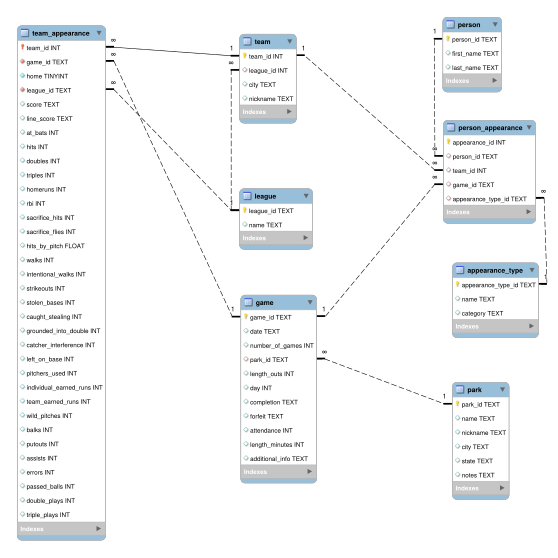

In [15]:
SVG(filename = '../SQL Schemas/MLB_Retrosheet.svg')

### Tables with no foreign relations

Let us briefly comment on this choice, focusing for the moment on the tables without foreign relations, which will be the first to be created:
* In `person`, the `debut` column is omitted as it can be obtained from other tabes. 
We also omit data on coaches as it is not present in the game log. 
* In `park`, we do not include the `start`, `end`, and `league` columns which can be deduced from other tables.
* We create a separate table, `league`, to include league names as older ones are not well known. 
* We also create a separate table, `appearance_type`, for the types of appearance (players with positions, umpires, managers, and awards).

Let us first create the `person` table. 
To this end, we first deal with the fact that the IDs are not unique:

In [16]:
run_query('SELECT * FROM personcode')['id'].value_counts()

beyea801    2
bourj001    1
glenb001    1
olerj001    1
radcr101    1
           ..
fishe101    1
gillh101    1
cicoa101    1
reith101    1
dotsr001    1
Name: id, Length: 21027, dtype: int64

In [17]:
run_query('SELECT * FROM personcode WHERE id = "beyea801"')

,id,last,first,play debut,mgr debut,coach debut,ump debut
0,beyea801,Beyeler,Arnie,None,None,None,None
1,beyea801,Beyeler,Arnie,None,None,04/01/2013,None


Since the second entry has all the information of the first plus the date of his debut as a coach, we can simply delete the first one.

In [18]:
run_command('DELETE FROM personcode WHERE id="beyea801" AND `coach debut` IS NULL')

Create the `person` table:

In [19]:
c1 = '''
CREATE TABLE person (
    person_id TEXT PRIMARY KEY,
    first_name TEXT, 
    last_name TEXT
)
'''

# select only one line per id
c2 = '''
INSERT INTO person 
SELECT 
    DISTINCT id, 
    first, 
    last
FROM personcode
'''

run_command(c1)
run_command(c2)
run_query('SELECT * FROM person LIMIT 10')

,person_id,first_name,last_name
0,aardd001,David,Aardsma
1,aaroh101,Hank,Aaron
2,aarot101,Tommie,Aaron
3,aased001,Don,Aase
4,abada001,Andy,Abad
5,abadf001,Fernando,Abad
6,abadj101,John,Abadie
7,abbae101,Ed,Abbaticchio
8,abbeb101,Bert,Abbey
9,abbec101,Charlie,Abbey


Create the `park` table:

In [20]:
c1 = '''
CREATE TABLE park (
    park_id TEXT PRIMARY KEY,
    name TEXT,
    nickname TEXT,
    city TEXT,
    state TEXT,
    notes TEXT
)
'''

c2 = '''
INSERT INTO park
SELECT 
    parkid, 
    name, 
    aka, 
    city, 
    state, 
    notes
FROM parkcode
'''

run_command(c1)
run_command(c2)
run_query('SELECT * FROM park LIMIT 10')

,park_id,name,nickname,city,state,notes
0,ALB01,Riverside Park,None,Albany,NY,TRN:9/11/80;6/15&9/10/1881;5/16-5/18&5/30/1882
1,ALT01,Columbia Park,None,Altoona,PA,None
2,ANA01,Angel Stadium of Anaheim,Edison Field; Anaheim Stadium,Anaheim,CA,None
3,ARL01,Arlington Stadium,None,Arlington,TX,None
4,ARL02,Rangers Ballpark in Arlington,The Ballpark in Arlington; Ameriquest Fl,Arlington,TX,None
5,ATL01,Atlanta-Fulton County Stadium,None,Atlanta,GA,None
6,ATL02,Turner Field,None,Atlanta,GA,None
7,ATL03,Suntrust Park,None,Atlanta,GA,None
8,BAL01,Madison Avenue Grounds,None,Baltimore,MD,WS3
9,BAL02,Newington Park,None,Baltimore,MD,BL1:1872-74; BL4:1873; BL2: 1882


Then the `league` table:

In [21]:
c1 = '''
CREATE TABLE league (
    league_id TEXT PRIMARY KEY,
    name TEXT
)
'''

c2 = '''
INSERT INTO league (league_id, name)
VALUES
    ('NL', 'National League'),
    ('AL', 'American League'),
    ('AA', 'Double-A'),
    ('UA', 'Union Associate'),
    ('FL', 'Florida State League'),
    ('PL', "Players' National League")
'''

run_command(c1)
run_command(c2)
run_query('SELECT * FROM league')

,league_id,name
0,NL,National League
1,AL,American League
2,AA,Double-A
3,UA,Union Associate
4,FL,Florida State League
5,PL,Players' National League


Finally, let us create the `appearance_type` table: 

In [22]:
c1 = '''
CREATE TABLE appearance_type (
    appearance_type_id TEXT PRIMARY KEY,
    name TEXT,
    category TEXT
)
'''

c2 = '''
INSERT INTO appearance_type  (appearance_type_id, name, category)
VALUES
    ('O1', 'Batter 1', 'offense'),
    ('O2', 'Batter 2', 'offense'),
    ('O3', 'Batter 3', 'offense'),
    ('O4', 'Batter 4', 'offense'),
    ('O5', 'Batter 5', 'offense'),
    ('O6', 'Batter 6', 'offense'),
    ('O7', 'Batter 7', 'offense'),
    ('O8', 'Batter 8', 'offense'),
    ('O9', 'Batter 9', 'offense'),
    ('D1', 'Pitcher', 'defense'),
    ('D2', 'Catcher', 'defense'),
    ('D3', '1st Base', 'defense'),
    ('D4', '2nd Base', 'defense'),
    ('D5', '3rd Base', 'defense'),
    ('D6', 'Shortstop', 'defense'),
    ('D7', 'Left Field', 'defense'),
    ('D8', 'Center Field', 'defense'),
    ('D9', 'Right Field', 'defense'),
    ('D10', 'Unknown Position', 'defense'),
    ('UHP', 'Home Plate', 'umpire'),
    ('U1B', 'First Base', 'umpire'),
    ('U2B', 'Second Base', 'umpire'),
    ('U3B', 'Third Base', 'umpire'),
    ('ULF', 'Left Field', 'umpire'),
    ('URF', 'Right Field', 'umpire'),
    ('MM', 'Manager', 'manager'),
    ('AWP', 'Winning Pitcher', 'award'),
    ('ALP', 'Losing Pitcher', 'award'),
    ('ASP', 'Saving Pitcher', 'award'),
    ('AWB', 'Winning RBI Batter', 'award'),
    ('PSP', 'Starting Pitcher', 'pitcher')
'''

run_command(c1)
run_command(c2)
run_query('SELECT * FROM appearance_type ')

,appearance_type_id,name,category
0,O1,Batter 1,offense
1,O2,Batter 2,offense
2,O3,Batter 3,offense
3,O4,Batter 4,offense
4,O5,Batter 5,offense
5,O6,Batter 6,offense
6,O7,Batter 7,offense
7,O8,Batter 8,offense
8,O9,Batter 9,offense
9,D1,Pitcher,defense


### Buiding the `game` and `team` tables

We now build the two tables having foreign keys relating to the above ones. 
First, a few comments on their schemas:
* In the `team` table, we do not include the `start`, `end`, and `sequence` columns as they can be derived from other tables. 
* In `game`, 
    * we include only columns which do not refer to a specific player or team, which can be found in the `appearance` and `team` tables, 
    * we do not include the day of the week, which can be derived from the date, 
    * the `day_night` columns is raplaced by `day`, which will be an integer interpreted as a boolean. 
    
We first need to deal with the fact that the `abbreviation` column in the `teamabr` table contains a duplicate:

In [23]:
run_query('SELECT * FROM teamabr WHERE abbreviation = "MIL"')

,abbreviation,league,city,nickname,first_year,last_year
0,MIL,AL,Milwaukee,Brewers,1970,1997
1,MIL,NL,Milwaukee,Brewers,1998,2010


This is due to a team having shifted leagues between the years 1997 and 1998. 
To resolve this ambiguity, we shall define the primary key as a composite key of `team_id` and `league_id`.

Creating the `team` table, and adding three missing entries, obtained from `game_log`: 

In [24]:
c1 = '''
CREATE TABLE team (
    team_id TEXT,
    league_id TEXT,
    city TEXT,
    nickname TEXT,
    PRIMARY KEY (team_id, league_id),
    FOREIGN KEY (league_id) REFERENCES league(league_id)
)
'''

c2 = '''
INSERT INTO team 
SELECT 
    abbreviation,
    league, 
    city, 
    nickname
FROM teamabr
'''

# manually insert the missing values
c3 = '''
INSERT INTO team (team_id, league_id)
VALUES
    ("BL5", "AA"),
    ("CN4", "NL"),
    ("HOU", "AL"),
    ("MIA", "NL")
'''

run_command(c1)
run_command(c2)
run_command(c3)
run_query('SELECT * FROM team LIMIT 10')

,team_id,league_id,city,nickname
0,BS1,None,Boston,Braves
1,CH1,None,Chicago,White Stockings
2,CL1,None,Cleveland,Forest Cities
3,FW1,None,Ft. Wayne,Kekiongas
4,NY2,None,New York,Mutuals
5,PH1,None,Philadelphia,Athletics
6,RC1,None,Rockford,Forest Citys
7,TRO,None,Troy,Haymakers
8,WS3,None,Washington,Olympics
9,BL1,None,Baltimore,Lord Baltimores


Let us now create the `game` table: 

In [25]:
c1 = '''
CREATE TABLE game (
    game_id TEXT PRIMARY KEY,
    date TEXT,
    number_of_game INTEGER,
    park_id TEXT,
    length_outs INTEGER,
    day INTEGER, 
    completion TEXT, 
    forfeit TEXT,
    attendance INTEGER,
    length_minutes INTEGER,
    additional_info TEXT,
    FOREIGN KEY (park_id) REFERENCES park(park_id)
)
'''

c2 = '''
INSERT INTO game
SELECT 
    game_id,
    date, 
    number_game,
    park_id, 
    outs,
    CASE 
        WHEN `day/night` = "D" THEN 1
        WHEN `day/night` = "N" THEN 0
        ELSE NULL
    END, 
    completion, 
    forfeit, 
    attendance, 
    time_min,
    additional_information
FROM game_log
'''

run_command(c1)
run_command(c2)
run_query('SELECT * FROM game LIMIT 10')

,game_id,date,number_of_game,park_id,length_outs,day,completion,forfeit,attendance,length_minutes,additional_info
0,FW1187105040,18710504,0,FOR01,54,1,None,None,200.0,120.0,None
1,WS3187105050,18710505,0,WAS01,54,1,None,None,5000.0,145.0,HTBF
2,RC1187105060,18710506,0,RCK01,54,1,None,None,1000.0,140.0,None
3,CH1187105080,18710508,0,CHI01,54,1,None,None,5000.0,150.0,None
4,TRO187105090,18710509,0,TRO01,54,1,None,None,3250.0,145.0,HTBF
5,CL1187105110,18710511,0,CLE01,48,1,None,V,2500.0,120.0,None
6,CL1187105130,18710513,0,CIN01,54,1,None,None,1200.0,150.0,None
7,FW1187105130,18710513,0,FOR01,54,1,None,None,1500.0,105.0,None
8,FW1187105150,18710515,0,FOR01,54,1,None,None,NaN,140.0,None
9,BS1187105160,18710516,0,BOS01,54,1,None,None,2500.0,NaN,HTBF


### Building the `team_appearance` table

Let us now build the `team_appearance` table. 
Its primary key will be composed of the team and game IDs. 
Its `home` column contains 0 for the visiting team and 1 for the home team.

In [26]:
c1 = '''
CREATE TABLE team_appearance (
    team_id TEXT, 
    game_id TEXT,
    home INT, 
    league_id TEXT, 
    score TEXT,
    line_score TEXT,
    at_bats INTEGER,
    hits INTEGER,
    doubles INTEGER,
    triples INTEGER,
    homeruns INTEGER,
    rbi INTEGER,
    sacrifice_hits INTEGER,
    sacrifice_flies INTEGER,
    walks INTEGER,
    intentional_walks INTEGER,
    strikeouts INTEGER,
    stolen_bases INTEGER,
    caught_stealing INTEGER,
    grounded_into_double INTEGER,
    first_catcher_interference INTEGER,
    left_on_base INTEGER,
    pitchers_used INTEGER,
    individual_earned_runs INTEGER,
    team_earned_runs INTEGER,
    wild_pitches INTEGER, 
    balks INTEGER,
    putouts INTEGER,
    assists INTEGER,
    errors INTEGER,
    passed_balls INTEGER,
    double_plays INTEGER,
    triple_plays INTEGER,
    PRIMARY KEY (team_id, game_id),
    FOREIGN KEY (team_id, league_id) REFERENCES team(team_id, league_id),
    FOREIGN KEY (game_id) REFERENCES game(game_id),
    FOREIGN KEY (league_id) REFERENCES league(league_id)
)
'''

c2 = '''
INSERT INTO team_appearance
SELECT 
    visiting_team, 
    game_id,
    0, 
    visiting_team_league, 
    visiting_team_score,
    visiting_line_score,
    `visiting_at-bats`,
    visiting_hits,
    visiting_doubles,
    visiting_triples,
    visiting_homeruns,
    visiting_rbi,
    visiting_sacrifice_hits,
    visiting_sacrifice_flies,
    visiting_walks,
    visiting_intentional_walks,
    visiting_strikeouts,
    visiting_stolen,
    visiting_caught,
    visiting_grounded,
    visiting_awarded_first,
    visiting_left_on_base,
    visiting_pitchers_used,
    visiting_individual_earned_runs,
    visiting_team_earned_runs,
    visiting_wild_pitches, 
    visiting_balks,
    visiting_putouts,
    visiting_assists,
    visiting_errors,
    visiting_passed_balls,
    visiting_double_plays,
    visiting_triple_plays

FROM game_log
UNION 
SELECT 
    home_team, 
    game_id,
    1, 
    home_team_league, 
    home_team_score,
    home_line_score,
    `home_at-bats`,
    home_hits,
    home_doubles,
    home_triples,
    home_homeruns,
    home_rbi,
    home_sacrifice_hits,
    home_sacrifice_flies,
    home_walks,
    home_intentional_walks,
    home_strikeouts,
    home_stolen,
    home_caught,
    home_grounded,
    home_awarded_first,
    home_left_on_base,
    home_pitchers_used,
    home_individual_earned_runs,
    home_team_earned_runs,
    home_wild_pitches, 
    home_balks,
    home_putouts,
    home_assists,
    home_errors,
    home_passed_balls,
    home_double_plays,
    home_triple_plays
FROM game_log
'''

run_command(c1)
run_command(c2)
run_query('SELECT * FROM team_appearance LIMIT 10')

,team_id,game_id,home,league_id,score,line_score,at_bats,hits,doubles,triples,homeruns,rbi,sacrifice_hits,sacrifice_flies,walks,intentional_walks,strikeouts,stolen_bases,caught_stealing,grounded_into_double,first_catcher_interference,left_on_base,pitchers_used,individual_earned_runs,team_earned_runs,wild_pitches,balks,putouts,assists,errors,passed_balls,double_plays,triple_plays
0,ALT,ALT188404300,1,UA,2,nan,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None
1,ALT,ALT188405020,1,UA,3,nan,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None
2,ALT,ALT188405030,1,UA,5,nan,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None
3,ALT,ALT188405050,1,UA,2,nan,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None
4,ALT,ALT188405100,1,UA,9,nan,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None
5,ALT,ALT188405120,1,UA,3,nan,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None
6,ALT,ALT188405140,1,UA,2,nan,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None
7,ALT,ALT188405150,1,UA,7,nan,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None
8,ALT,ALT188405160,1,UA,6,nan,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None
9,ALT,ALT188405170,1,UA,8,nan,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None


### Building the `person_appearance` table

Finally, let us build the `person_appearance` table. 
Its primary key will be an integer.

In [27]:
c1 = '''
CREATE TABLE person_appearance (
    appearance_id INTEGER PRIMARY KEY,
    person_id TEXT,
    team_id TEXT,
    league_id TEXT,
    game_id TEXT,
    appearance_type_id TEXT,
    FOREIGN KEY (person_id) REFERENCES person(person_id),
    FOREIGN KEY (team_id, league_id) REFERENCES team(team_id, league_id),
    FOREIGN KEY (game_id) REFERENCES game(game_id),
    FOREIGN KEY (appearance_type_id) REFERENCES appearance_type(appearance_type_id)
)
'''

c2 = '''
INSERT INTO person_appearance (
    game_id,
    team_id,
    person_id,
    appearance_type_id
)
    SELECT
        game_id,
        NULL,
        home_plate_umpire_id,
        "UHP"
    FROM game_log
    WHERE home_plate_umpire_id IS NOT NULL

UNION

    SELECT
        game_id,
        NULL,
        lf_umpire_id,
        "ULF"
    FROM game_log
    WHERE lf_umpire_id IS NOT NULL
    
UNION

    SELECT
        game_id,
        NULL,
        rf_umpire_id,
        "URF"
    FROM game_log
    WHERE rf_umpire_id IS NOT NULL
    
UNION

    SELECT
        game_id,
        NULL,
        rf_umpire_id,
        "URF"
    FROM game_log
    WHERE rf_umpire_id IS NOT NULL
    
UNION

    SELECT
        game_id,
        NULL,
        `1B_umpire_id`,
        "U1B"
    FROM game_log
    WHERE `1B_umpire_id` IS NOT NULL
    
UNION

    SELECT
        game_id,
        NULL,
        `2B_umpire_id`,
        "U1B"
    FROM game_log
    WHERE `1B_umpire_id` IS NOT NULL
    
UNION

    SELECT
        game_id,
        NULL,
        `3B_umpire_id`,
        "U1B"
    FROM game_log
    WHERE `1B_umpire_id` IS NOT NULL

UNION

    SELECT
        game_id,
        visiting_team,
        visiting_manager_id,
        "MM"
    FROM game_log
    WHERE visiting_manager_id IS NOT NULL

UNION

    SELECT
        game_id,
        home_team,
        home_manager_id,
        "MM"
    FROM game_log
    WHERE home_manager_id IS NOT NULL

UNION

    SELECT
        game_id,
        CASE
            WHEN home_team_score > visiting_team_score THEN home_team
            ELSE visiting_team
            END,
        winning_pitcher_id,
        "AWP"
    FROM game_log
    WHERE winning_pitcher_id IS NOT NULL
    
UNION

    SELECT
        game_id,
        CASE
            WHEN home_team_score < visiting_team_score THEN home_team
            ELSE visiting_team
            END,
        losing_pitcher_id,
        "ALP"
    FROM game_log
    WHERE losing_pitcher_id IS NOT NULL
    
UNION

    SELECT
        game_id,
        CASE
            WHEN home_team_score > visiting_team_score THEN home_team
            ELSE visiting_team
            END,
        saving_pitcher_id,
        "ASP"
    FROM game_log
    WHERE saving_pitcher_id IS NOT NULL
    
UNION

    SELECT
        game_id,
        CASE
            WHEN home_team_score > visiting_team_score THEN home_team
            ELSE visiting_team
            END,
        winning_RBI_batter_id,
        "AWB"
    FROM game_log
    WHERE winning_RBI_batter_id IS NOT NULL
    
UNION

    SELECT
        game_id,
        visiting_team,
        visiting_starting_pitcher_id,
        "PSP"
    FROM game_log
    WHERE visiting_starting_pitcher_id IS NOT NULL
    
UNION

    SELECT
        game_id,
        home_team,
        home_starting_pitcher_id,
        "PSP"
    FROM game_log
    WHERE home_starting_pitcher_id IS NOT NULL
    
'''

for i in range(1,10):
    c2 += '''
    UNION

    SELECT
        game_id,
        visiting_team,
        visiting_starting_player_{0}_id,
        "D{0}"
    FROM game_log
    WHERE visiting_starting_player_{0}_id IS NOT NULL
    
    UNION

    SELECT
        game_id,
        home_team,
        home_starting_player_{0}_id,
        "D{0}"
    FROM game_log
    WHERE home_starting_player_{0}_id IS NOT NULL
    '''.format(i)

run_command(c1)
run_command(c2)
run_query('SELECT * FROM person_appearance LIMIT 10')

,appearance_id,person_id,team_id,league_id,game_id,appearance_type_id
0,1,maplb901,None,None,ALT188404300,UHP
1,2,curte801,ALT,None,ALT188404300,MM
2,3,murpj104,ALT,None,ALT188404300,PSP
3,4,hodnc101,SLU,None,ALT188404300,PSP
4,5,sullt101,SLU,None,ALT188404300,MM
5,6,hoopm101,None,None,ALT188405020,UHP
6,7,curte801,ALT,None,ALT188405020,MM
7,8,learj102,ALT,None,ALT188405020,PSP
8,9,sullt101,SLU,None,ALT188405020,MM
9,10,taylb103,SLU,None,ALT188405020,PSP


### Drop the original tables

Let us now drop the tables `game_log`, `parkcode`, `personcode`, and `teamabr` which are not usefiul any more.

In [28]:
for table in ['game_log', 'parkcode', 'personcode', 'teamabr']:
    run_command('DROP TABLE ' + table)

## Delete the intermediate files

In [29]:
!rm $path'game_log.csv'
!rm $path'mlb.db'

## Conclusion

In this project, we have seen how to use the Pandas and sqlite3 databases to build an SQL database from different source files. 
Doing so, we got a glimpse of some of the problems that may occur and questions that arise in building a database, in particular redeundant or missing information and, most importantly, how to design the database so to make the information easily accessible. 
The philosophy we have followed is to build one table for each concept of interest, starting from those with no foreign key. 
This strategy should be applicable to more complex databases.